# Import libraries

In [1]:
# load libraries
import utils as u
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [2]:
plt.rcParams.update({
    'axes.titlesize': 14,     # Title font size
    'axes.labelsize': 14,     # X and Y axis labels font size
    'xtick.labelsize': 12,    # X tick labels font size
    'ytick.labelsize': 12,    # Y tick labels font size
    'legend.fontsize': 14,    # Legend font size
    'figure.titlesize': 14    # Figure title font size
})

# Load the data

In [3]:
import pickle as pkl

# load the stored data
file_name = 'sec2_data_output.pkl'

with open(file_name, 'rb') as f:
    data = pkl.load(f)

wl = data['wavelength']
df = data['df']

In [4]:
df.columns

Index(['manga_id', 'teff', 'teff_err', 'logg', 'logg_err', 'feh', 'feh_err',
       'flux', 's2n', 'teff_class', 'teff_label', 'logg_label', 'feh_class',
       'feh_label'],
      dtype='object')

In [5]:
X = np.stack(df['flux'].values, axis=0)

y_t = np.array(df['teff_label']).astype('int')
y_g = np.array(df['logg_label']).astype('int')
y_m = np.array(df['feh_label']).astype('int')

# Feature selection

In [6]:
print('Wavelength range: {:.2f}  {:.2f}'.format(wl[0], wl[-1]))

spec_size = X[0].shape[0]

print('Number of values per spectrum:', spec_size)

Wavelength range: 3621.60  10353.81
Number of values per spectrum: 4563


   **Lines to be selected**
   1. Ca II K (3934 A) & H (3968 A) lines: Key indicators in A-type stars, showing strength variances linked to temperature and luminosity effects (Gray & Corbally 2009)
   2. Fe I (4046 A): Often used with hydrogen line Hδ for temperature classification, especially in F-type and later-type stars (Gray & Corbally 2009)
   3. 2 spectral lines can help us classify stars from B to M (Brice & Andonie 2019):
      - H_delta (4102 A): present in A, B, F, G
      - Ca I (4227 A): present in F, G, K, M
   4. G-band CH (4300 A): Prominent in late-G to K-type stars and is sensitive to surface gravity (Gray & Corbally 2009)
   5. He II (4686 A): dominates O-type stars (Gray & Corbally 2009)
   6. TiO band (4955 A): at least one TiO band is needed for M-type (Gray & Corbally 2014)
   7. Fe I (5269 A) & Fe II (5018 A): for metallicity classification (Santos et al. 2004) [DOI: 10.1051/0004-6361:20034469]

In [7]:
spec_lines = {'line_wl':
    [3934, 3968, 4046, 4102, 4227, 4300, 4686, 4955, 5018, 5269],
              'bounds':
    [8]*10}

new_X = u.select_features(X, wl, spec_lines['line_wl'][0])
for i in range(1, len(spec_lines['line_wl'])):
    # print(f"Line {i+1} of {len(spec_lines['line_wl'])}, Current shape: {new_X.shape}", end="\r")
    new_X = np.concatenate((new_X, u.select_features(X, wl, spec_lines['line_wl'][i], spec_lines['bounds'][i])), axis=1)
print(f"\nFinal shape: {new_X.shape}")

Wavelength bounds (3934): 3926.45 - 3940.94
Wavelength bounds (3968): 3960.96 - 3975.58
Wavelength bounds (4046): 4038.31 - 4053.22
Wavelength bounds (4102): 4094.49 - 4109.60
Wavelength bounds (4227): 4218.91 - 4234.48
Wavelength bounds (4300): 4292.40 - 4308.24
Wavelength bounds (4686): 4677.35 - 4694.62
Wavelength bounds (4955): 4945.38 - 4963.64
Wavelength bounds (5018): 5008.41 - 5026.90
Wavelength bounds (5269): 5258.96 - 5278.37

Final shape: (59085, 170)


# PCA plot

This is only done to plot the PCA plot and choose the number of features. Neither the scaler nor the PCA object fitted using the entire dataset are used later. New scalers are fitted using only training sets to transfrom the data.

In [8]:
scaler = MinMaxScaler()
# fit the scaler and transform the data
X_scaled = scaler.fit_transform(new_X)

In [9]:
pca = PCA(n_components=X_scaled.shape[1])
# fit the PCA object and transform the data
X_pca = pca.fit_transform(X_scaled)

In [10]:
n_comp = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.9995)[0][0] + 1
print(f"More than 99.95% of the variance in the data is explained by {n_comp} PCA components.")

More than 99.95% of the variance in the data is explained by 9 PCA components.


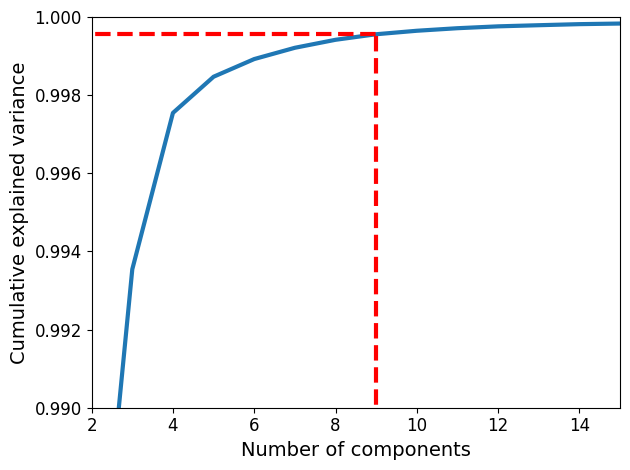

In [11]:
y_pca = np.cumsum(pca.explained_variance_ratio_)[8]

plt.plot(range(1,21), np.cumsum(pca.explained_variance_ratio_)[:20], linewidth=3)
plt.plot([9,9], [0.88, y_pca], color='red', linestyle='--', linewidth=3)
plt.plot([1,9], [y_pca, y_pca], color='red', linestyle='--', linewidth=3)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.ylim(0.99,1)
plt.xlim(2,15)
#plt.grid(True)

plt.tight_layout()

plt.savefig('PCA.pdf');

# Preprocess and save data files

In [15]:
# t_eff
u.preprocess_set(new_X, y_t, 'teff')

Data saved in file sec3_1_data_output_teff.pkl


In [16]:
# log g
u.preprocess_set(new_X, y_g, 'logg')

Data saved in file sec3_1_data_output_logg.pkl


In [17]:
# [Fe/H]
u.preprocess_set(new_X, y_m, 'feh')

Data saved in file sec3_1_data_output_feh.pkl
